# Imports

In [1]:
import json
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import preprocessing as preproc
from sklearn.decomposition import PCA
import numpy as np

from scipy import stats

# https://stackoverflow.com/questions/52285104/3d-scatterplots-with-hue-colormap-and-legend
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

try:
  from google.colab import drive
  drive.mount('/content/drive')

  COLAB = True
except ModuleNotFoundError:
  COLAB = False

from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
cm_blue_grad = ListedColormap(newcolors, name='CustomBlue')

cm_bool = sns.color_palette("blend:#31bdff,white", as_cmap=True)


%matplotlib inline

/tmp/ipykernel_164239/3615078541.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Blues_r', 128)
/tmp/ipykernel_164239/3615078541.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Blues', 128)


# Load Data

In [2]:
df = pd.read_parquet("diabetic_data_cleaned.parquet")

# fix some types that parquet didn't get right
df["admission_type_id"] = df["admission_type_id"].astype("category")
df["discharge_disposition_id"] = df["discharge_disposition_id"].astype("category")
df["admission_source_id"] = df["admission_source_id"].astype("category")

# creating a new column to identify readmission, regardelss of the number of days
df["readmitted_any"] = df["readmitted"] == "NO"

TGT2 = "readmitted_any"

display(df.shape)
display(df.dtypes)
display(df.head(2).T)

(100244, 32)

race                        category
gender                      category
age                         category
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
metformin                   category
repaglinide                 category
glimepiride                 category
glipizide                   category
glyburide                   category
pioglitazone                category
rosiglitazone               category
insulin                     category
g

,1,2
race,Caucasian,AfricanAmerican
gender,Female,Female
age,[10-20),[20-30)
admission_type_id,1,1
discharge_disposition_id,1,1
admission_source_id,7,7
time_in_hospital,3,2
payer_code,NaN,NaN
medical_specialty,NaN,NaN
num_lab_procedures,59,11


In [3]:
with open("data_dictionary.json", "r") as f:
  data_info = json.load(f)

NUM_COLUMNS = data_info["Numeric Columns"]
CAT_COLUMNS = data_info["Categorical Columns"]
TGT = data_info["Target"]

# Univariate Analysis

## Numeric Columns

### Summary Statistics

In [4]:
df[NUM_COLUMNS].describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,100244.0,4.420275,2.991273,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,100244.0,43.173716,19.691484,1.0,32.0,44.0,57.0,132.0
num_procedures,100244.0,1.350275,1.710913,0.0,0.0,1.0,2.0,6.0
num_medications,100244.0,16.117823,8.116424,1.0,11.0,15.0,20.0,81.0
number_outpatient,100244.0,0.372561,1.274074,0.0,0.0,0.0,0.0,42.0
number_emergency,100244.0,0.199014,0.933541,0.0,0.0,0.0,0.0,76.0
number_inpatient,100244.0,0.639470,1.262773,0.0,0.0,0.0,1.0,21.0
number_diagnoses,100244.0,7.497007,1.839537,3.0,6.0,8.0,9.0,16.0


### Plots

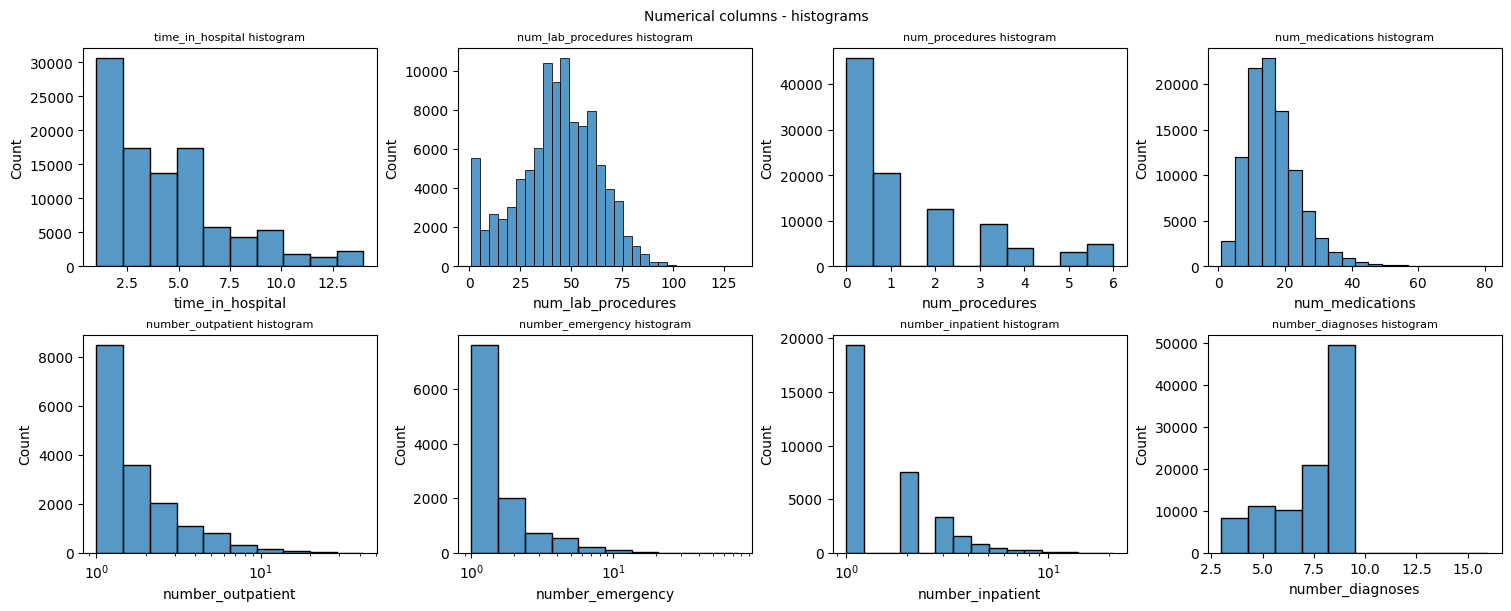

In [5]:
num_cols = 4

fig, axes = plt.subplots((len(NUM_COLUMNS) // num_cols), num_cols, figsize=(15, 6), constrained_layout=True)

fig.suptitle("Numerical columns - histograms", fontsize=10)

plot_nums = {
  'time_in_hospital' : { "bins": 10 },
  'num_lab_procedures' : { "bins": 30 },
  'num_procedures' : { "bins": 10 },
  'num_medications' : { "bins": 20 },
  'number_outpatient' : { "bins": 10, "log_scale": (True, False) },
  'number_emergency' : { "bins": 10, "log_scale": (True, False) },
  'number_inpatient' : { "bins": 15, "log_scale": (True, False) },
  'number_diagnoses' : { "bins": 10 }
}

for i, (col, kwargs) in enumerate(plot_nums.items()):
  ax=axes[i // num_cols, i % num_cols]
  ax.set_title(f"{col} histogram", fontsize=8)

  sns.histplot(df[col],
               bins=kwargs["bins"],
               ax=ax,
               log_scale=kwargs.get("log_scale", (False, False)))

## Categorical columns

### Summary Statistics

In [6]:
df[CAT_COLUMNS].describe().T.sort_values(by="unique", ascending=False)

,count,unique,top,freq
diag_3,100244,789,250,11533
diag_2,100244,743,428,6657
diag_1,100244,715,428,6853
medical_specialty,50762,72,InternalMedicine,14384
discharge_disposition_id,100244,26,1,59005
admission_source_id,100244,17,7,56799
payer_code,60789,17,MC,32223
age,100244,10,[70-80),25898
admission_type_id,100244,8,1,53232
race,100244,5,Caucasian,76759


### Plots

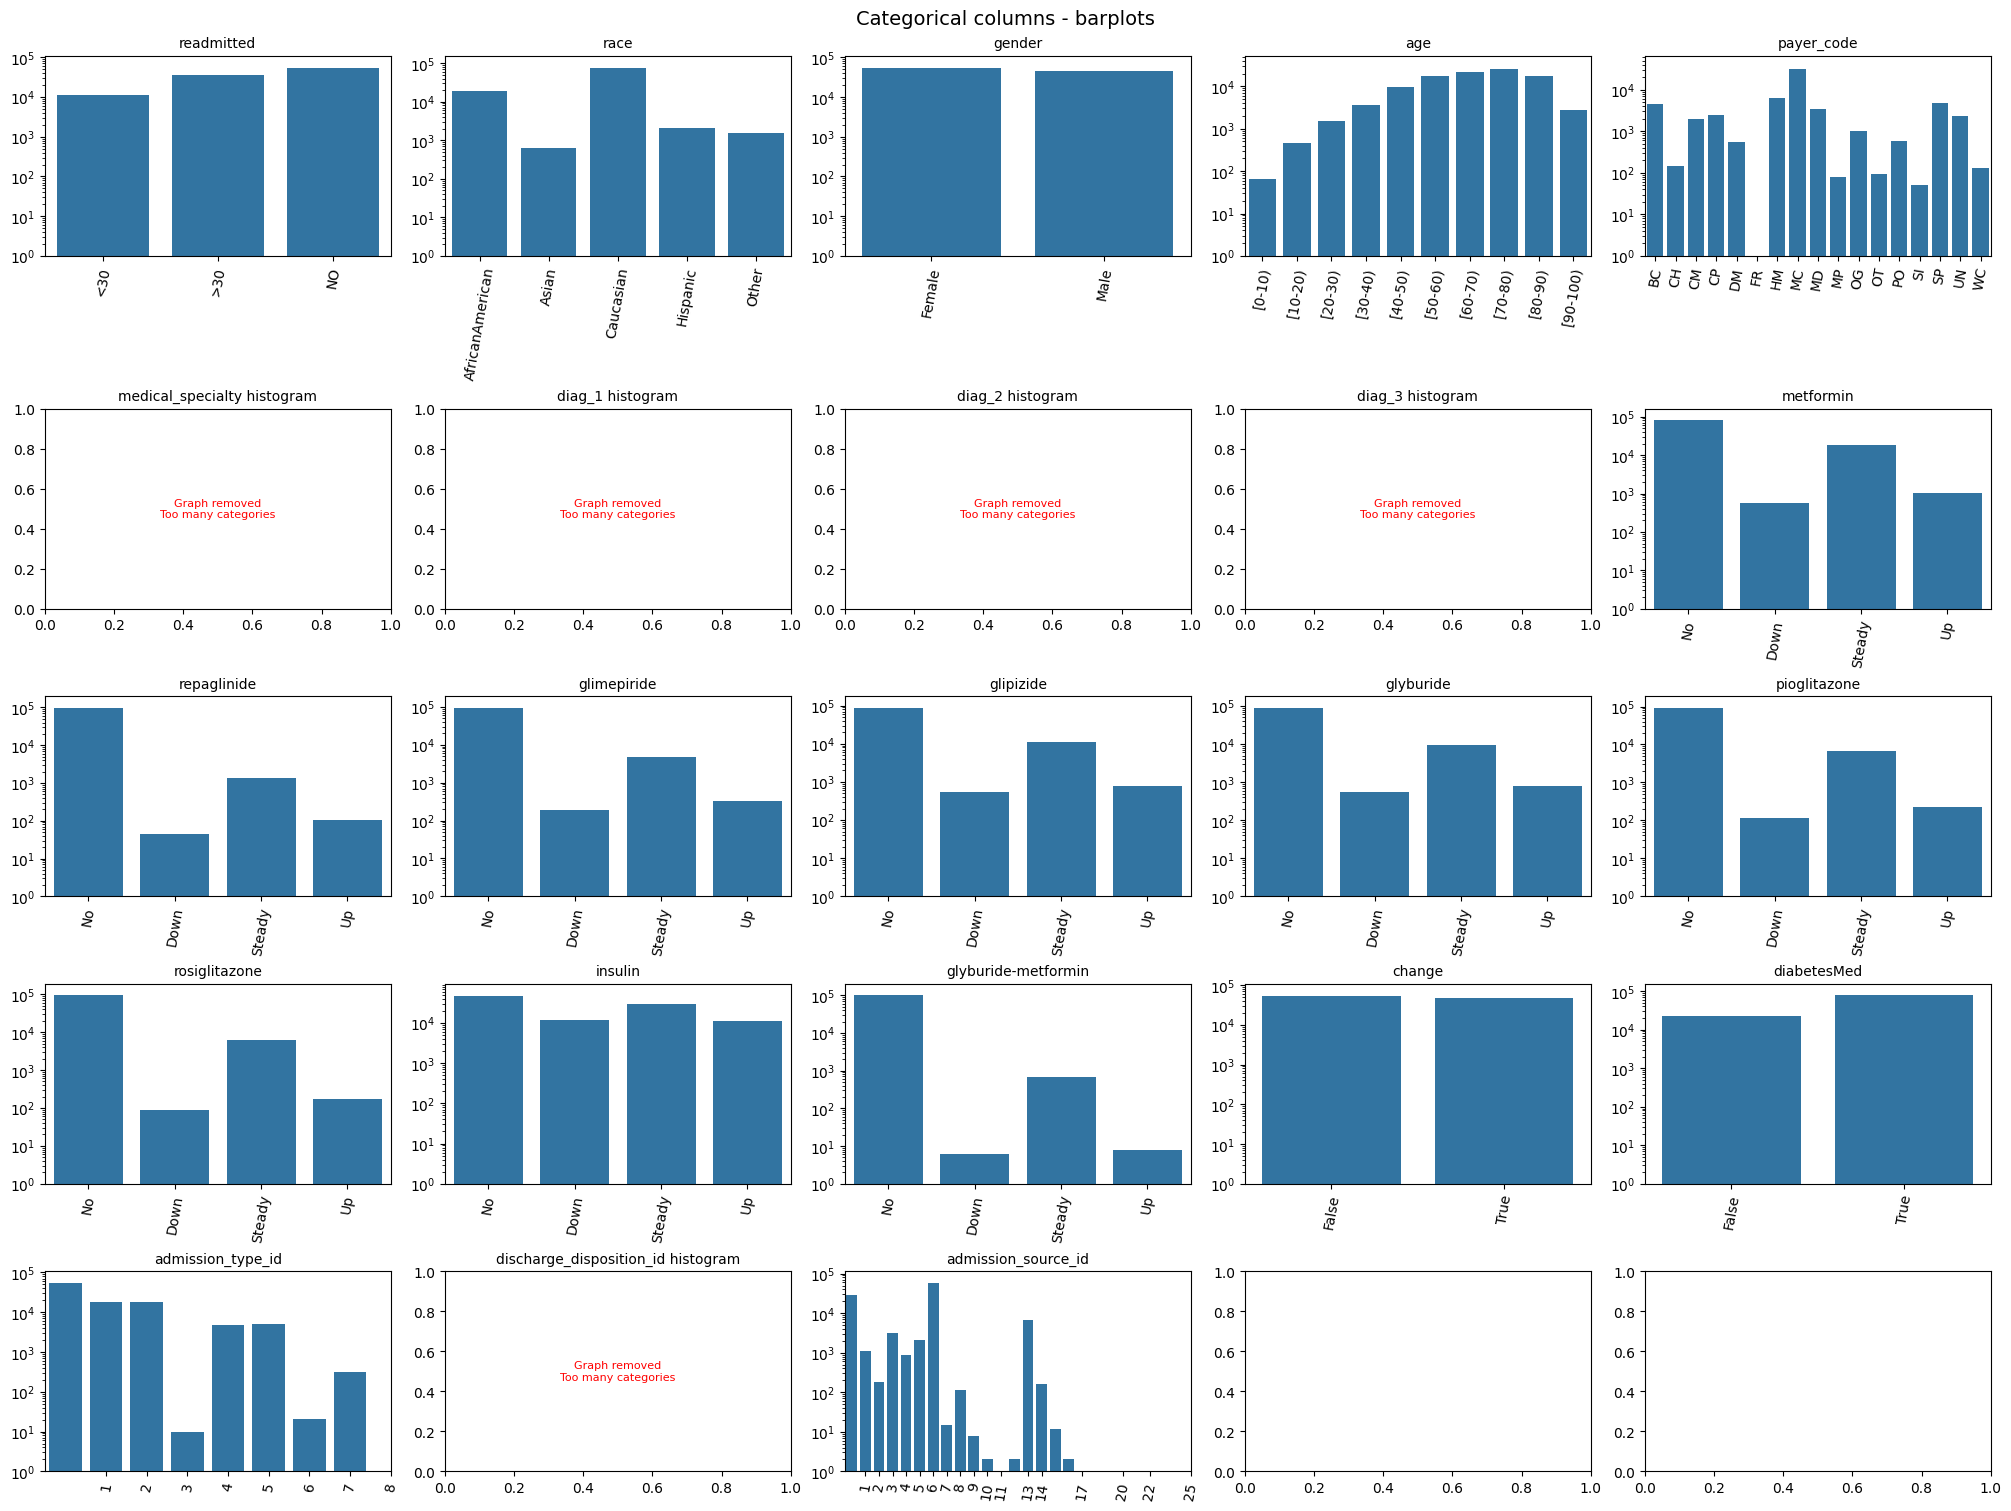

In [7]:
num_cols = 5

cols = [TGT] + CAT_COLUMNS

fig, axes = plt.subplots(len(cols) // num_cols + 1, num_cols, figsize=(20, 15), constrained_layout=True)

fig.suptitle("Categorical columns - barplots", fontsize=14)

CAT_MANY_CATEGORIES = []

VERBOSE = False

# display the number of unique values for each categorical column in cols
for i, col in enumerate(cols):
  if VERBOSE:
    print(df[col].value_counts().sort_values(), end="\n\n")

  ax=axes[i // num_cols, i % num_cols]
  ax.set_title(f"{col} histogram", fontsize=10)

  freq_table = df[col].value_counts().sort_index()
  
  x=freq_table.index.tolist()
  y=freq_table.values

  if freq_table.shape[0] > 20:
    ax.text(0.5,
            0.5,
            "Graph removed\nToo many categories",
            transform=ax.transAxes,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8,
            color='red')
    CAT_MANY_CATEGORIES.append(col)
    continue

  #df[col].value_counts().sort_values().plot(kind="bar", ax=ax, rot=45, xlabel=None)
  p = sns.barplot(x=x, y=y, ax=ax)
  p.set_title(f"{col}", fontsize=10)
  p.set_xticks(x)
  p.set_xticklabels(x, rotation=80)
  p.set_xlabel(None)
  p.set_yscale("log")
  p.set_ylim(bottom=1, top=max(y) * 2)

# Bivariate Analysis

## Numeric vs TGT

### Plots

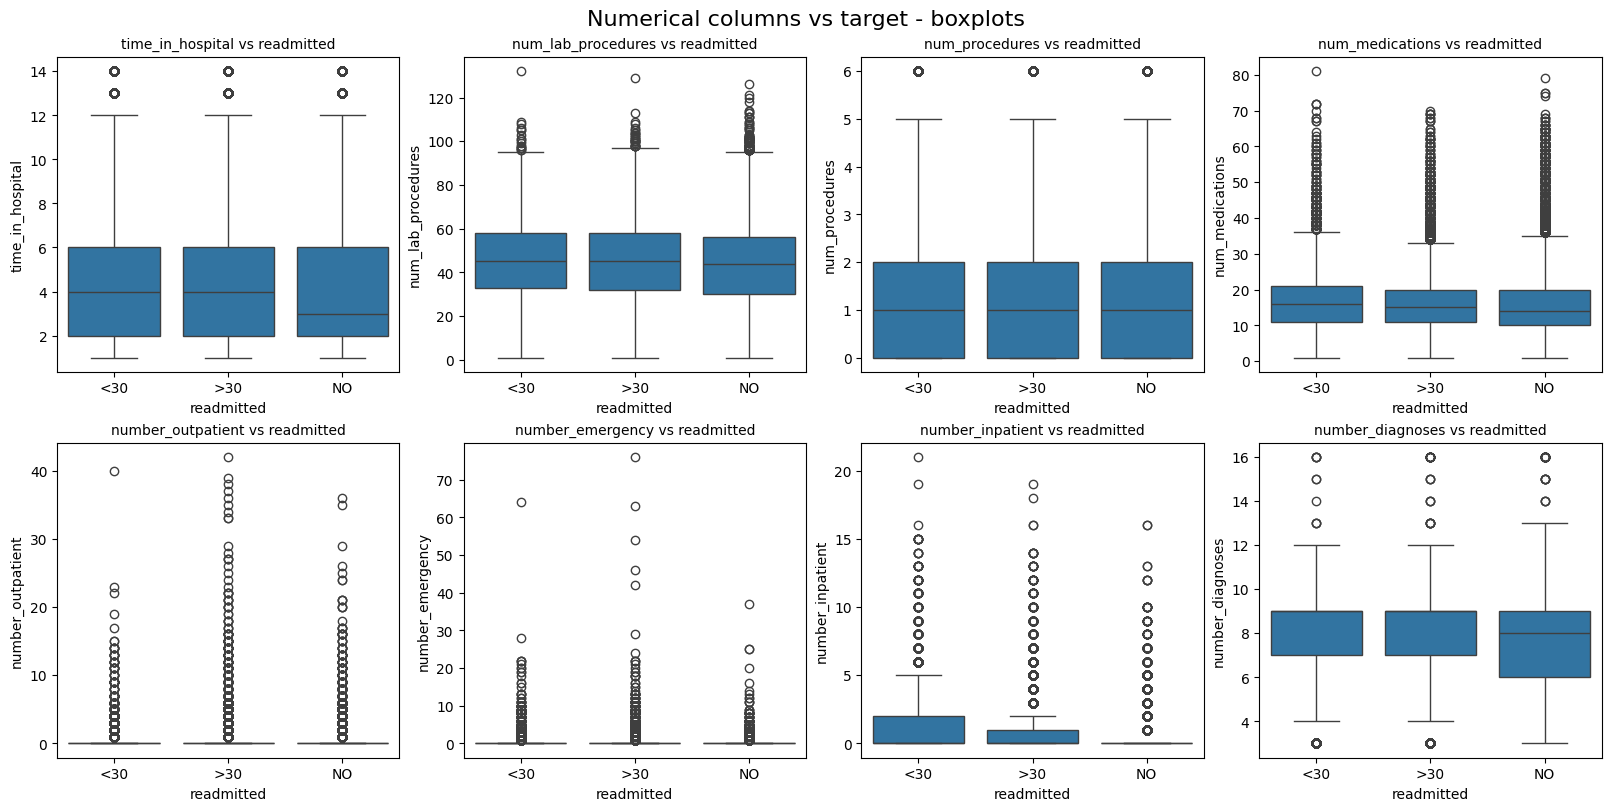

In [8]:
num_cols = 4

fig, axes = plt.subplots(len(NUM_COLUMNS) // num_cols, num_cols, figsize=(16, 8), constrained_layout=True)
    
fig.suptitle("Numerical columns vs target - boxplots", fontsize=16)

for i, col in enumerate(NUM_COLUMNS):
  ax=axes[i // num_cols, i % num_cols]
  ax.set_title(f"{col} vs {TGT}", fontsize=10)

  sns.boxplot(y=col, x=TGT, data=df, ax=ax)

### Summary Statistics

In [9]:
anova_results = []
for col in NUM_COLUMNS:
    groups = df.groupby(TGT2, observed=False)[col].apply(np.array)
    f, p = stats.f_oneway(groups[0], groups[1])
    anova_results.append((col, f, p))

anova_results = pd.DataFrame(anova_results, columns=["Variable", "F", "p-value"])
anova_results["p-value < 0.05"] = anova_results["p-value"] < 0.05

display(anova_results
        .style
        .set_caption("ANOVA test results - Predicting Readmission vs No Readmission")
        .background_gradient(axis=0, gmap=anova_results["p-value < 0.05"], cmap=cm_bool, vmin=0, vmax=1))

/tmp/ipykernel_164239/798533659.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f, p = stats.f_oneway(groups[0], groups[1])


,Variable,F,p-value,p-value < 0.05
0,time_in_hospital,240.875195,0.000000,True
1,num_lab_procedures,143.479388,0.000000,True
2,num_procedures,220.530975,0.000000,True
3,num_medications,187.255839,0.000000,True
4,number_outpatient,665.949786,0.000000,True
5,number_emergency,1057.697011,0.000000,True
6,number_inpatient,4888.446000,0.000000,True
7,number_diagnoses,1165.465486,0.000000,True


In [10]:
anova_results = []
for col in NUM_COLUMNS:
    groups = df.groupby(TGT, observed=False)[col].apply(np.array)
    f, p = stats.f_oneway(groups["<30"], groups[">30"])
    anova_results.append((col, f, p))

anova_results = pd.DataFrame(anova_results, columns=["Variable", "F", "p-value"])
anova_results["p-value < 0.05"] = anova_results["p-value"] < 0.05
display(anova_results
        .style
        .set_caption("ANOVA test results - Predicting <30 vs >30 days readmission")
        .background_gradient(axis=0, gmap=anova_results["p-value < 0.05"], cmap=cm_bool, vmin=0, vmax=1))

,Variable,F,p-value,p-value < 0.05
0,time_in_hospital,69.424063,0.000000,True
1,num_lab_procedures,3.244503,0.071670,False
2,num_procedures,2.894656,0.088880,False
3,num_medications,52.236582,0.000000,True
4,number_outpatient,13.722661,0.000212,True
5,number_emergency,30.208933,0.000000,True
6,number_inpatient,515.330482,0.000000,True
7,number_diagnoses,3.504548,0.061207,False


In [11]:
anova_results = []
for col in NUM_COLUMNS:
    groups = df.groupby(TGT, observed=False)[col].apply(np.array)
    f, p = stats.f_oneway(groups["NO"], groups[">30"])
    anova_results.append((col, f, p))

anova_results = pd.DataFrame(anova_results, columns=["Variable", "F", "p-value"])
anova_results["p-value < 0.05"] = anova_results["p-value"] < 0.05
display(anova_results
        .style
        .set_caption("ANOVA test results - Predicting NO readmission vs >30 days readmission")
        .background_gradient(axis=0, gmap=anova_results["p-value < 0.05"], cmap=cm_bool, vmin=0, vmax=1))

,Variable,F,p-value,p-value < 0.05
0,time_in_hospital,124.527133,0.000000,True
1,num_lab_procedures,107.252734,0.000000,True
2,num_procedures,203.944776,0.000000,True
3,num_medications,100.083972,0.000000,True
4,number_outpatient,655.754299,0.000000,True
5,number_emergency,872.985235,0.000000,True
6,number_inpatient,3581.999920,0.000000,True
7,number_diagnoses,937.603694,0.000000,True


In [12]:
anova_results = []
for col in NUM_COLUMNS:
    groups = df.groupby(TGT, observed=False)[col].apply(np.array)
    f, p = stats.f_oneway(groups["NO"], groups["<30"])
    anova_results.append((col, f, p))

anova_results = pd.DataFrame(anova_results, columns=["Variable", "F", "p-value"])
anova_results["p-value < 0.05"] = anova_results["p-value"] < 0.05

display(anova_results
        .style
        .set_caption("ANOVA test results - Predicting NO readmission vs <30 days readmission")
        .background_gradient(axis=0, gmap=anova_results["p-value < 0.05"], cmap=cm_bool, vmin=0, vmax=1))


,Variable,F,p-value,p-value < 0.05
0,time_in_hospital,260.123401,0.000000,True
1,num_lab_procedures,75.843887,0.000000,True
2,num_procedures,58.894324,0.000000,True
3,num_medications,179.434816,0.000000,True
4,number_outpatient,206.257080,0.000000,True
5,number_emergency,1024.224202,0.000000,True
6,number_inpatient,5075.576664,0.000000,True
7,number_diagnoses,470.063575,0.000000,True


### Correlation

<Axes: >

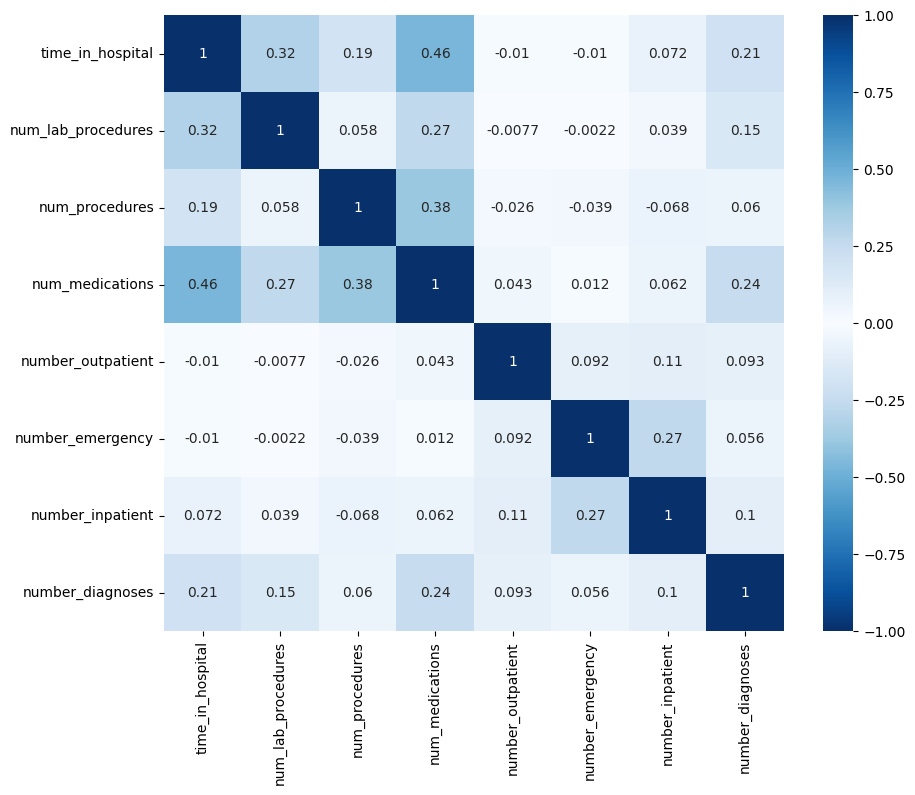

In [13]:
corr = df[NUM_COLUMNS].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap=cm_blue_grad, vmin=-1, vmax=1)

The conclusion here is, all the numerical columns are statistically significant to predict the target variable, though num_lab_procedures, num_procedures and number_diagnoses presented a high p-value to explain >30 and <30 days readmission.

## Categorical vs TGT

### Plots

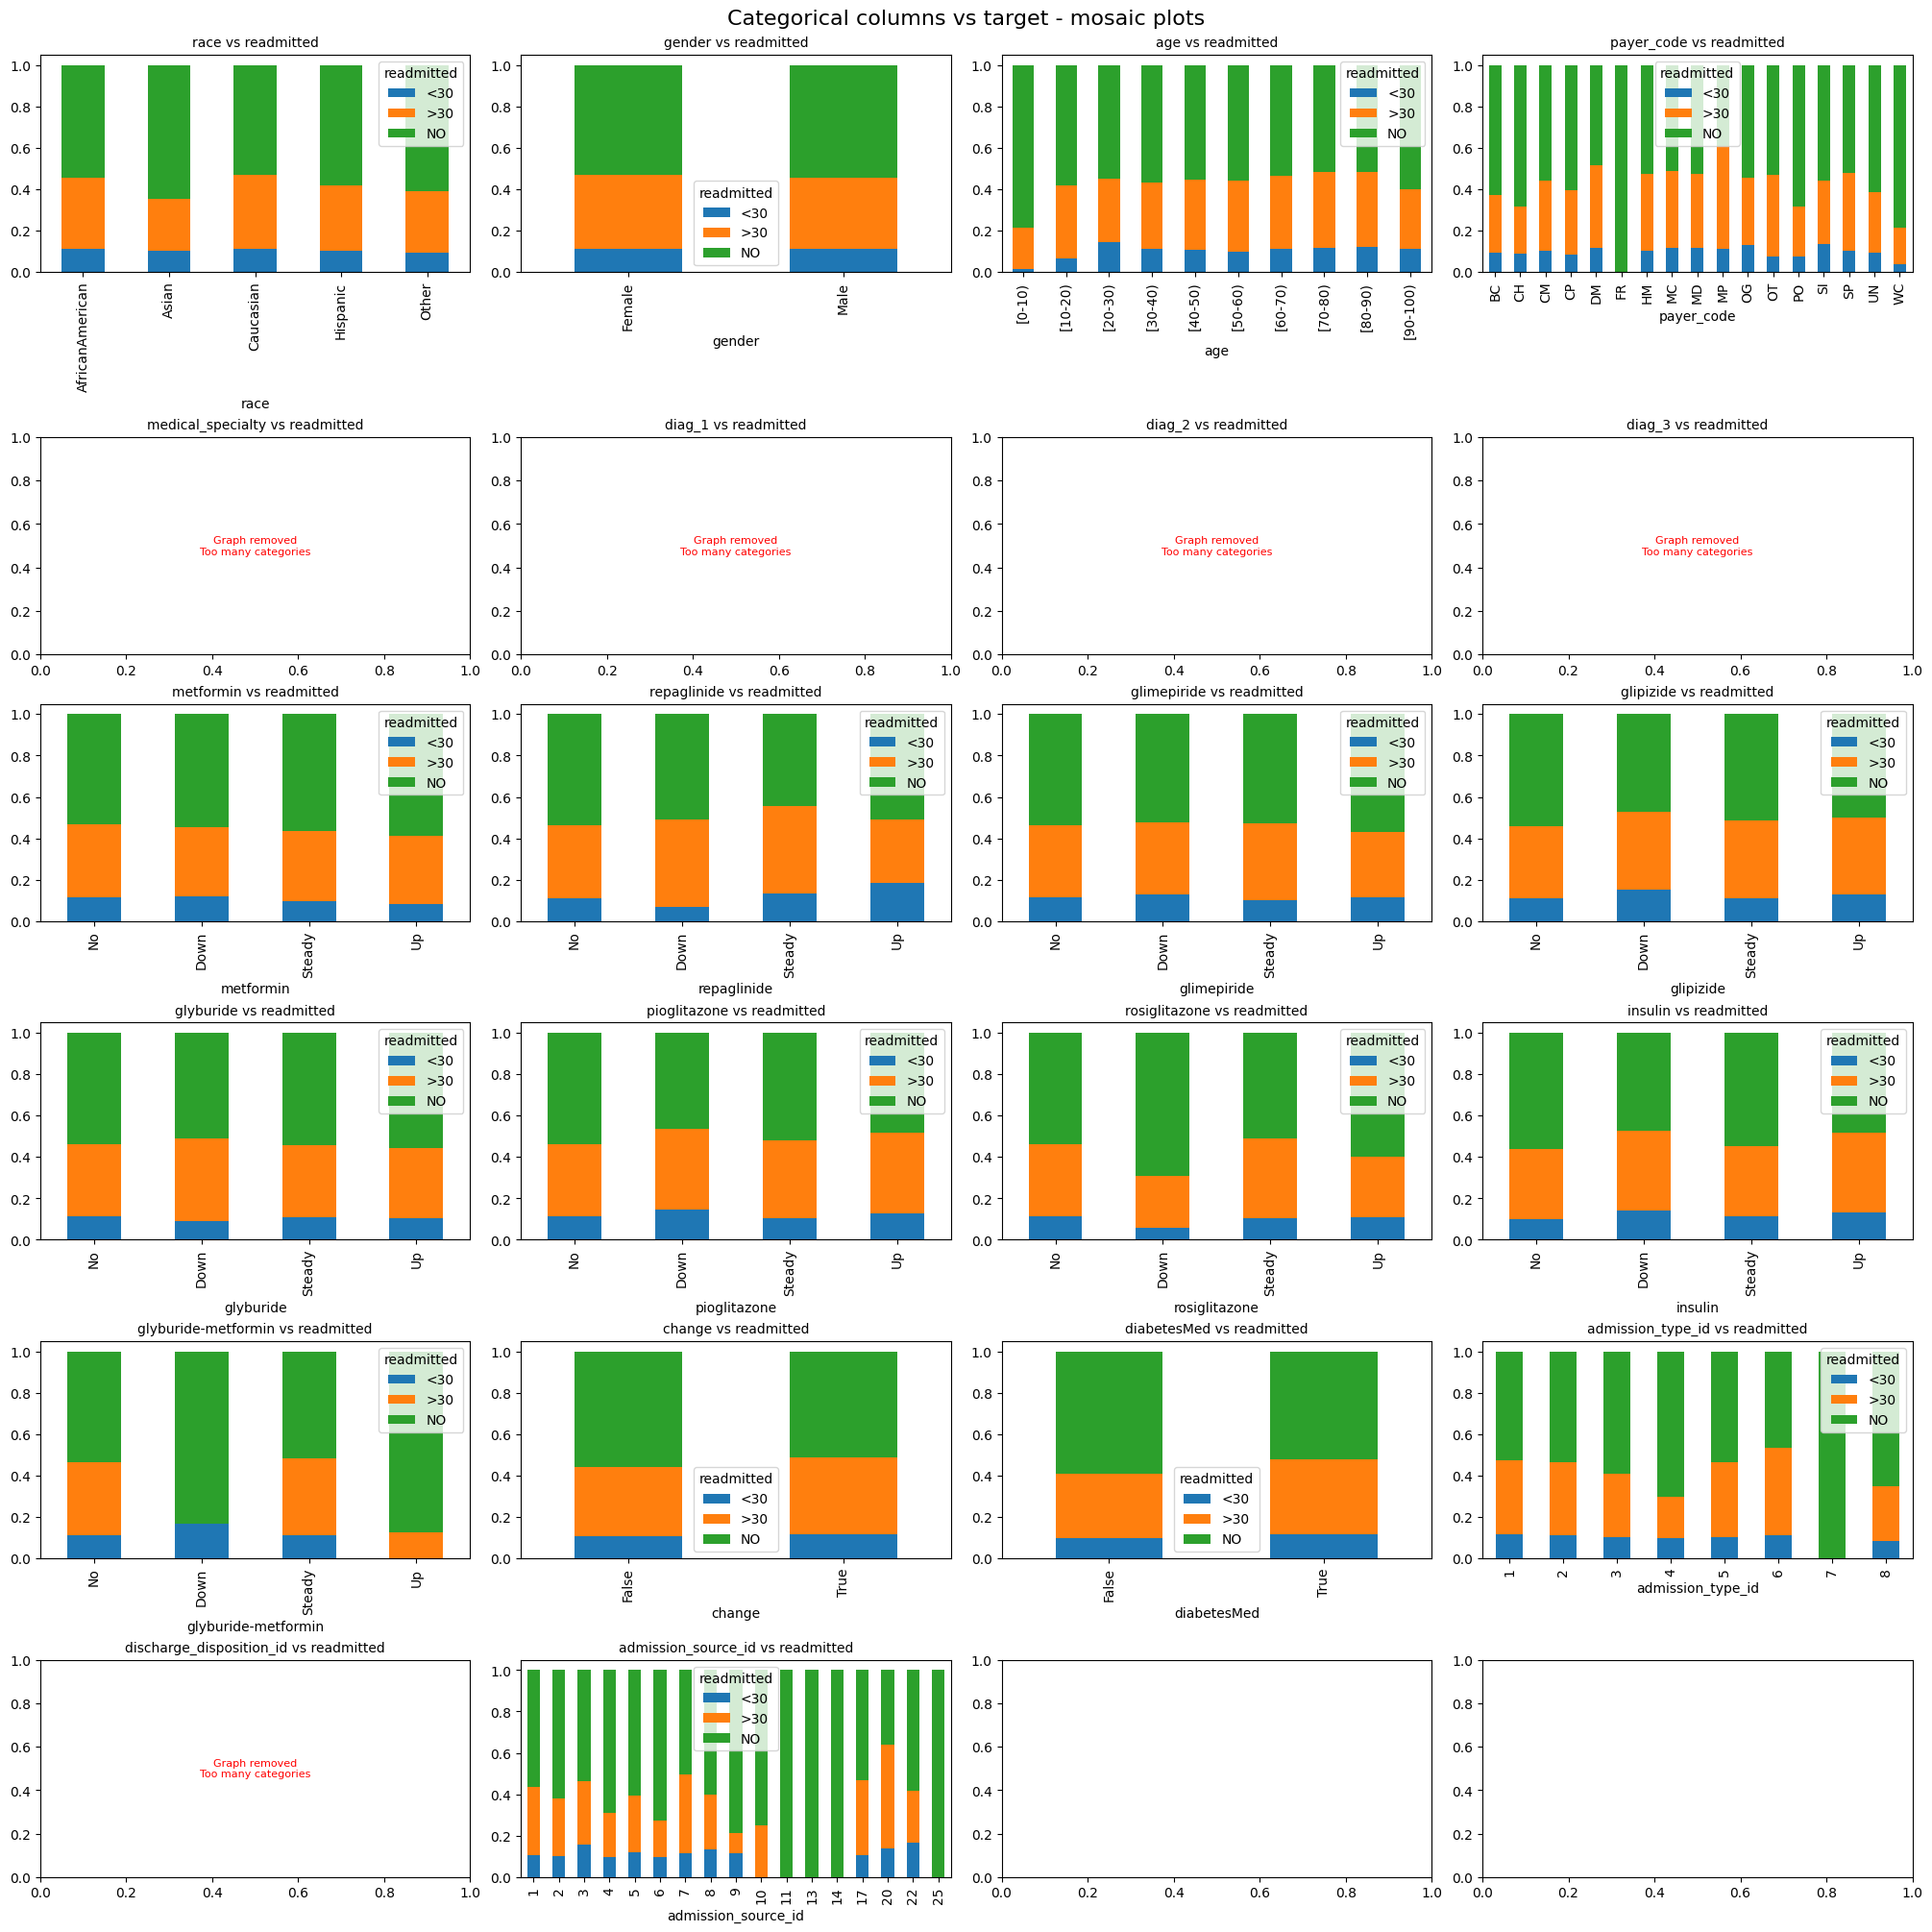

In [14]:
# stack bar plots for categorical variables against the target - maybe replot this in R using mosaic is a better idea

num_cols = 4

fig, axes = plt.subplots(len(CAT_COLUMNS) // num_cols + 1, num_cols, figsize=(20, 20), constrained_layout=True)

fig.suptitle("Categorical columns vs target - mosaic plots", fontsize=16)

for i, col in enumerate(CAT_COLUMNS):
  ax=axes[i // num_cols, i % num_cols]
  ax.set_title(f"{col} vs {TGT}", fontsize=10)

  freq_table = df[col].value_counts().sort_index()
  if freq_table.shape[0] > 20:
    ax.text(0.5,
            0.5,
            "Graph removed\nToo many categories",
            transform=ax.transAxes,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8,
            color='red')
    CAT_MANY_CATEGORIES.append(col)
    continue

  mosaic = pd.crosstab(df[col], df[TGT], normalize="index")
  mosaic.plot(kind="bar", stacked=True, ax=ax)


### Summary Statistics

In [15]:
# running chi2 tests for all categorical variables against the target
chi2_results = []

for col in CAT_COLUMNS:
    cont_table = pd.crosstab(df[col], df[TGT])
    chi2, p, dof, expected = stats.chi2_contingency(cont_table)
    chi2_results.append((col, chi2, p))

chi2_results = pd.DataFrame(chi2_results, columns=["Variable", "Chi2", "p-value"])
chi2_results["p-value < 0.05"] = chi2_results["p-value"] < 0.05
display(chi2_results
        .style
        .set_caption("Chi2 test results - Categorical Columns vs TGT with <30 days, >30 days and NO readmission")
        .background_gradient(axis=0, gmap=chi2_results["p-value < 0.05"], cmap=cm_bool, vmin=0, vmax=1))

,Variable,Chi2,p-value,p-value < 0.05
0,race,89.336154,0.000000,True
1,gender,32.108913,0.000000,True
2,age,240.449923,0.000000,True
3,payer_code,482.454627,0.000000,True
4,medical_specialty,1129.306608,0.000000,True
5,diag_1,4842.681757,0.000000,True
6,diag_2,3897.163399,0.000000,True
7,diag_3,3780.854742,0.000000,True
8,metformin,102.743633,0.000000,True
9,repaglinide,56.755370,0.000000,True


In [16]:
# running chi2 tests for all categorical variables against the target
chi2_results = []

for col in CAT_COLUMNS:
    cont_table = pd.crosstab(df[col], df[TGT2])
    chi2, p, dof, expected = stats.chi2_contingency(cont_table)
    chi2_results.append((col, chi2, p))

chi2_results = pd.DataFrame(chi2_results, columns=["Variable", "Chi2", "p-value"])
chi2_results["p-value < 0.05"] = chi2_results["p-value"] < 0.05
display(chi2_results
        .style
        .set_caption("Chi2 test results - Categorical Columns vs readmission / No Readmission")
        .background_gradient(axis=0, gmap=chi2_results["p-value < 0.05"], cmap=cm_bool))

,Variable,Chi2,p-value,p-value < 0.05
0,race,85.774284,0.000000,True
1,gender,30.025186,0.000000,True
2,age,180.887477,0.000000,True
3,payer_code,450.393219,0.000000,True
4,medical_specialty,916.128892,0.000000,True
5,diag_1,3463.251914,0.000000,True
6,diag_2,2906.842814,0.000000,True
7,diag_3,2713.155302,0.000000,True
8,metformin,81.944038,0.000000,True
9,repaglinide,49.613944,0.000000,True


#### chi-squared test among only the categorical variables

<Axes: title={'center': 'Chi2 test results (p-values greater than .05) - Categorical Columns vs Categorical Columns'}, xlabel='Variable2', ylabel='Variable1'>

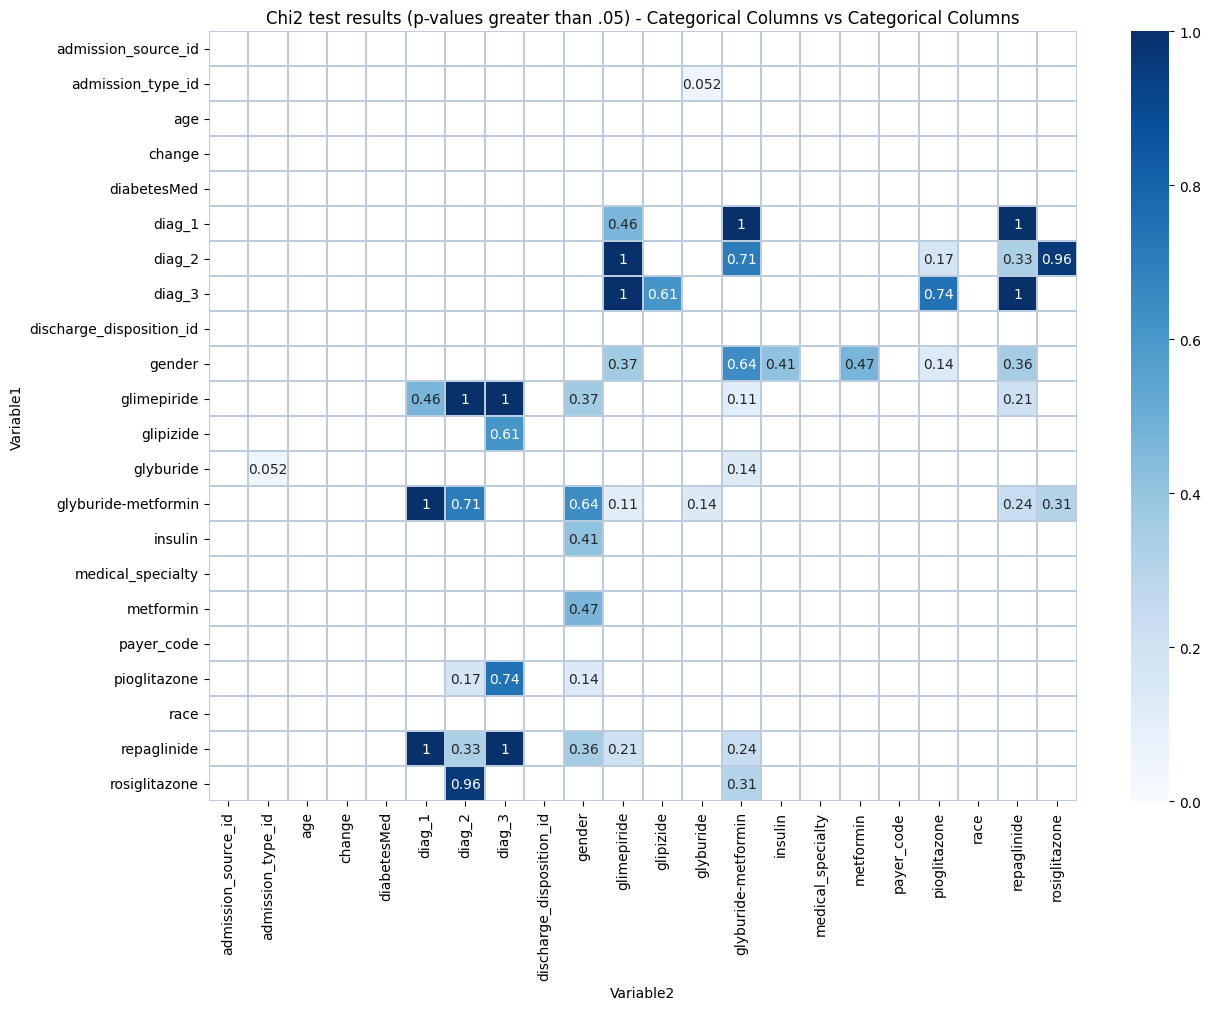

In [17]:
# chi-squared test for the categorical variables 2 by 2
chi2_results = []

for col1 in CAT_COLUMNS:
  for col2 in CAT_COLUMNS:
    cont_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = stats.chi2_contingency(cont_table)
    chi2_results.append((col1, col2, chi2, p))

chi2_results = pd.DataFrame(chi2_results, columns=["Variable1", "Variable2", "Chi2", "p-value"])
chi2_results["p-value < 0.05"] = chi2_results["p-value"] < 0.05

# pivor this chi2_results dataframe to create a heatmap with the p-values
chi2_results_pivot = chi2_results.pivot(index="Variable1", columns="Variable2", values="p-value")
chi2_results_pivot = chi2_results_pivot.round(3)

plt.figure(figsize=(14, 10))
# add a title
plt.title("Chi2 test results (p-values greater than .05) - Categorical Columns vs Categorical Columns")

# put a grid on the heatmap
sns.heatmap(chi2_results_pivot, annot=True, cmap="Blues", mask=chi2_results_pivot < 0.05, vmin=0, vmax=1, linewidths=.1, linecolor="#baccde")